# Piezoelectric Microcantilever Data Generator

## 1. 物理常数与参数设置

### 1.1 物理常数（固定不变）

| 名称             | 变量名      | 数值            | 单位    | 含义         |
|------------------|-------------|-----------------|---------|--------------|
| 杨氏模量         | `E`         | 169e9           | Pa      | 弹性模量     |
| 材料密度         | `rho`       | 2330            | kg/m³   | 硅密度       |
| 梁厚度           | `t`         | 25e-6           | m       | 梁截面厚度   |
| 真空介电常数     | `eps_0`     | 8.85e-12        | F/m     | 电场常数     |
| 第一模态参数     | `beta`      | 4.73      | -       | 固定根值     |

### 1.2 结构/电气参数（可扩展为变量）

| 名称               | 变量名            | 当前数值       | 单位   |采样点数| 说明              | 采样范围             |
|--------------------|-------------------|---------------|--------|------|-------------------|-------------------------|
| 梁宽               | `w_t`             | 10e-6         | m      | 16|梁的横向宽度      | [5e-6, 20e-6]           |
| 梁长               | `l_t`             | 500e-6        | m      | 19|梁的长度          | [100e-6, 1000e-6]       |
| 驱动电压           | `V`               | 5             | V      | 10|DC激励电压        | [1, 10]                 |
| 电极间隙           | `d`               | 6e-6          | m      | 9|顶/底电极间距     | [2e-6, 10e-6]           |
| 电极长度           | `electrode_length`| 700e-6        | m      | 81|电极长度          | [100e-6, 900e-6]        |
| 电极宽度           | `electrode_width` | 20e-6         | m      | 26|电极宽度          | [5e-6, 30e-6]           |
| 端部质量块宽度     | `w_c`             | 10e-6         | m      | 76|末端质量块宽度    | [5e-6, 20e-6]           |
| 端部质量块长度     | `l_c`             | 20e-6         | m      | 26|末端质量块长度    | [5e-6, 30e-6]           |
| 驱动Vac            | `Vac_ground`      | 5e-3          | V      | 1|小信号驱动电压    | 可微调                  |
| 品质因子          | `Q`                 | 10000 | -    | 19|机械品质因子 |[5000, 47500]|



### 1.3 扫描参数

| 名称 | 变量名   | 范围                 | 单位 | 采样点数 | 说明     |
| -- | ----- | ------------------ | -- | ---- | ------ |
| 梁宽 | `w_t` | \[5e-6, 20e-6]     | m  | 16   | 梁的横向宽度 |
| 梁长 | `l_t` | \[100e-6, 1000e-6] | m  | 19   | 梁的长度   |


In [1]:
import numpy as np

# ==== 1.1 物理常数 ====
E = 169e9               # 杨氏模量 (Pa)
rho = 2330              # 密度 (kg/m^3)
t = 25e-6               # 梁厚度 (m)
eps_0 = 8.85e-12        # 真空介电常数 (F/m)
beta = 4.73         # 第一阶模态根

# ==== 1.2 结构/电气参数（可扩展为区间）====
V = 5                      # 驱动电压 (V)
d = 6e-6                   # 电极间隙 (m)
electrode_length = 700e-6  # 电极长度 (m)
electrode_width = 20e-6    # 电极宽度 (m)
w_c = 10e-6                # 端部质量块宽度 (m)
l_c = 20e-6                # 端部质量块长度 (m)
Vac_ground = 5e-3          # 驱动Vac (V)
Q = 10000
# ==== 1.3 Q扫描参数 ====
w_t_list = np.linspace(5e-6, 20e-6, 160)      # 梁宽
l_t_list = np.linspace(100e-6, 1000e-6, 190)  # 梁长

# ==== 1.4 模态系数 ====
def calc_alpha_n(beta):
    denominator = np.cosh(beta) - np.cos(beta)
    if np.abs(denominator) < 1e-10:
        raise ValueError("alpha_n denominator too small")
    return (np.sin(beta) - np.sinh(beta)) / denominator

alpha_n = calc_alpha_n(beta)

# ==== 1.5 参数集 ====
params = dict(
    E=E, rho=rho, t=t, eps_0=eps_0, beta=beta, alpha_n=alpha_n,
    V=V, d=d, electrode_length=electrode_length, electrode_width=electrode_width,
    w_c=w_c, l_c=l_c, Vac_ground=Vac_ground, Q=Q
)

print("常数与可调参数设置完成。")

常数与可调参数设置完成。


## 2. 数据预处理：模态函数与梁参数计算

本节将根据物理模型，对微梁的模态形状函数、归一化模态、质量系数、刚度系数等参数进行数值预处理。  
所有步骤严格基于 Euler-Bernoulli 悬臂梁一阶模态理论，具体物理公式如下：

### 2.1 模态函数

模态函数的未归一化表达式为（见 PINNS_explonation.pdf）：
$$
\text{modeshape}_{\text{unnormalized}}(x) =
- \left[
-\sin\left(\frac{\beta x}{l_t}\right) +
\sinh\left(\frac{\beta x}{l_t}\right) +
\alpha_n\left(
-\cos\left(\frac{\beta x}{l_t}\right) +
\cosh\left(\frac{\beta x}{l_t}\right)
\right)
\right]
$$

归一化模态函数为：
$$
\text{modeshape}_1(x) = \frac{\text{modeshape}_{\text{unnormalized}}(x)}{\max(\text{modeshape}_{\text{unnormalized}})}
$$

### 2.2 梁参数的积分计算

- 质量系数：
  $$
  m_{\text{coef}_b} = \int_0^{l_t} [\text{modeshape}_1(x)]^2 \frac{dx}{l_t}
  $$

- 刚度系数：
  $$
  k_{\text{coef}_b} = \int_0^{l_t} \left[\frac{d^2}{dx^2}\text{modeshape}_1(x)\right]^2 \frac{dx}{l_t}
  $$
  $$
  k_{\text{coef}_b3} = \int_0^{l_t} \left[\frac{d}{dx}\text{modeshape}_1(x)\right]^2 \frac{dx}{l_t}
  $$

### 2.3 梁刚度、三次刚度、质量、固有角频率

- 梁的等效刚度：
  $$
  k_{tt} = \frac{k_{\text{coef}_b}}{12} E t \left(\frac{w_t}{l_t}\right)^3
  $$
- 三次刚度：
  $$
  k_{t3} = k_{\text{coef}_b3} E t \frac{w_t}{l_t^3}
  $$
- 质量：
  $$
  M = \rho\left( t w_t l_t m_{\text{coef}_b} + \text{electrode\_length} \times \text{electrode\_width} \times t + 2 w_c l_c t \right)
  $$
- 一阶固有角频率与频率：
  $$
  \omega_0 = \sqrt{\frac{k_t}{M}}
  $$
  $$
  f_0 = \frac{\omega_0}{2\pi}
  $$


In [2]:
import math
def simulate(w_t, l_t, params, numberofsmallelements=2000):
    # 1. 拿出必要参数
    E = params['E']
    rho = params['rho']
    t = params['t']
    beta = params['beta']
    alpha_n = params['alpha_n']
    electrode_length = params['electrode_length']
    electrode_width = params['electrode_width']
    w_c = params['w_c']
    l_c = params['l_c']
    
    # ---- 空间离散参数 ----
    length_x = np.linspace(0, l_t, numberofsmallelements, endpoint=False)
    
    # ---- 模态函数计算 ----
    modeshape_unnormalized = -(
        -np.sin(beta * length_x / l_t)
        + np.sinh(beta * length_x / l_t)
        + alpha_n * (-np.cos(beta * length_x / l_t) + np.cosh(beta * length_x / l_t))
    )
    max_mode = np.max(modeshape_unnormalized)
    if np.abs(max_mode) < 1e-12:
        raise ValueError("modeshape_unnormalized max too small!")
    modeshape1 = modeshape_unnormalized / max_mode
    
    # ---- 数值一二阶导数 ----
    second_derivative = (-1 / max_mode) * (beta ** 2) * (
        np.sin(beta * length_x / l_t)
        + np.sinh(beta * length_x / l_t)
        + alpha_n * (np.cos(beta * length_x / l_t) + np.cosh(beta * length_x / l_t))
    )
    first_derivative = (-1 / max_mode) * beta * (
        -np.cos(beta * length_x / l_t)
        + np.sinh(beta * length_x / l_t)
        + alpha_n * (np.sin(beta * length_x / l_t) + np.cosh(beta * length_x / l_t))
    )
    
    # ---- 积分求各系数 ----
    dx = length_x[1] - length_x[0]
    m_coef_b = np.sum(modeshape1 ** 2 * dx / l_t)
    k_coef_b = np.sum(second_derivative ** 2 * dx / l_t)
    k_coef_b3 = np.sum(first_derivative ** 2 * dx / l_t)
    
    # ---- 梁参数 ----
    k_tt = k_coef_b / 12 * E * t * ((w_t / l_t) ** 3)
    k_t3 = k_coef_b3 * E * t * w_t / (l_t ** 3)
    k_t = k_tt
    Mass = rho * (t * w_t * l_t * m_coef_b + electrode_length * electrode_width * t + w_c * l_c * t * 2)
    omega_0 = math.sqrt(k_t / Mass)
    freq_0 = omega_0 / (2 * math.pi)
    #print(f"预计算完成：m_coef_b={m_coef_b:.4e}, k_coef_b={k_coef_b:.4e}, k_coef_b3={k_coef_b3:.4e}")
    #print(f"k_tt={k_tt:.4e}, k_t3={k_t3:.4e}, Mass={Mass:.4e}, omega_0={omega_0:.4e}, freq_0={freq_0:.4e} Hz")
    # 结果字典，可扩展
    return {
        'w_t': w_t,
        'l_t': l_t,
        'm_coef_b': m_coef_b,
        'k_coef_b': k_coef_b,
        'k_coef_b3': k_coef_b3,
        'k_tt': k_tt,
        'k_t3': k_t3,
        'Mass': Mass,
        'omega_0': omega_0,
        'freq_0': freq_0
    }



## 3. 小批次数据生成（W_t,L_t扫描）

本节我们以品质因子 $W_t , L_t $ 为变量，采样多个 $W_t , L_t$ 值，计算对应的微梁谐振频率响应（`freq`）和电流响应（`m_c`）。  
每组$Q$下的响应对应161个激励相位点（$\phi$），形成一个完整的频谱曲线。  
所有核心参数（如$E$、$\rho$、$t$、$Q$等）均在开头代码区集中定义。  
数据最终以DataFrame结构保存，**主变量为W_t、L_t、freq、m_c**，其余所有常数参数合并进一个dict一同写入文件，便于后续Notebook调用。

### 3.1 主要计算公式说明

- **阻尼系数 $c$**  
  $$
  c = \frac{\sqrt{M k_t}}{Q}
  $$

- **谐振器动力学方程组（每个$\phi$点求解）：**  
  $$
  \begin{cases}
    -M\omega^2 y + (k_t - k_e)y + (k_{t3} - k_{e3})\frac{3}{4}y^3 - F_{ac}\cos(\phi) = 0 \\
    c \omega y - F_{ac}\sin(\phi) = 0
  \end{cases}
  $$
  - $F_{ac} = V_{ac} \cdot \mathrm{trans\_factor}$，为激励幅值

- **筛选规则：**  
  仅保留 $0 < \omega_0/2 < \omega < 3\omega_0/2$ 的正实根作为物理有效解

- **最终输出数据结构：**
  - `w_t,l_t`（扫描变量）
  - `freq`（长度161的频率响应数组）
  - `m_c`（长度161的电流响应数组）
  - 其余所有物理常数/参数打包进 `constants` dict，作为h5文件属性一起保存


In [3]:
import pandas as pd
import numpy as np
from sympy import symbols
from sympy.solvers.solveset import nonlinsolve

number_of_sim = 161
phi = np.linspace((10 / 180) * np.pi, (170 / 180) * np.pi, number_of_sim)


total = len(w_t_list) * len(l_t_list)
count = 0
results = []

for w_t in w_t_list:
    for l_t in l_t_list:
        # 1. 梁/模态参数计算
        res = simulate(w_t, l_t, params)
        k_t = res['k_tt']
        k_t3 = res['k_t3']
        Mass = res['Mass']
        freq_0 = res['freq_0']
        omega_0 = res['omega_0']
        m_coef_b = res['m_coef_b']
        k_coef_b = res['k_coef_b']
        k_coef_b3 = res['k_coef_b3']

        # 2. 电-机械耦合参数
        trans_factor = eps_0 * V * electrode_length * t / (d ** 2)
        k_e = 2 * trans_factor * V / d
        k_e3 = 4 * trans_factor * V / (d ** 3)
        c = np.sqrt(Mass * k_t) / Q

        # 3. 非线性谐振响应解
        freq = np.full(number_of_sim, np.nan)3
        m_c = np.full(number_of_sim, np.nan)
        for i in range(number_of_sim):
            vac = Vac_ground
            force_ac = vac * trans_factor
            x, y = symbols('x, y', reals=True)
            try:
                solutions = nonlinsolve([
                    -Mass * (x ** 2) * y + (k_t - k_e) * y + (k_t3 - k_e3) * (y ** 3) * 3 / 4 - force_ac * np.cos(phi[i]),
                    c * x * y - force_ac * np.sin(phi[i])
                ], [x, y])
                for sol in solutions:
                    if not (np.isreal(sol[0]) and np.isreal(sol[1]) and np.isfinite(float(sol[0])) and np.isfinite(float(sol[1]))):
                        continue
                    if omega_0 / 2 < float(sol[0]) < 3 * omega_0 / 2 and float(sol[0]) > 0:
                        freq[i] = float(sol[0]) / (2 * np.pi)
                        m_c[i] = float(sol[1]) * freq[i] * 2 * np.pi * trans_factor / 1e-9
                        break
            except Exception:
                continue
        results.append({
            'w_t': w_t,
            'l_t': l_t,
            'm_coef_b': m_coef_b,
            'k_coef_b': k_coef_b,
            'k_coef_b3': k_coef_b3,
            'k_tt': k_t,
            'k_t3': k_t3,
            'Mass': Mass,
            'omega_0': omega_0,
            'freq_0': freq_0,
            'trans_factor': trans_factor,
            'k_e': k_e,
            'k_e3': k_e3,
            'freq': freq,
            'm_c': m_c
        })
        count += 1
        print(f"Completed (w_t={w_t*1e6:.2f}um, l_t={l_t*1e6:.2f}um) [{count}/{total}]")

results_df = pd.DataFrame(results)

# 全局常数
constants = dict(
    E=E, rho=rho, t=t, eps_0=eps_0, beta=beta, alpha_n=alpha_n,
    V=V, d=d, electrode_length=electrode_length, electrode_width=electrode_width,
    w_c=w_c, l_c=l_c, Vac_ground=Vac_ground, Q=Q,
    phi=phi, number_of_sim=number_of_sim
)

with pd.HDFStore('./data/wt_lt_big.h5', 'w') as store:
    store['data'] = results_df
    store.get_storer('data').attrs.constants = constants

print("数据生成完成！所有 (w_t, l_t) 响应谱已写入 HDF5 文件。")


Completed (w_t=5.00um, l_t=100.00um) [1/30400]
Completed (w_t=5.00um, l_t=104.76um) [2/30400]
Completed (w_t=5.00um, l_t=109.52um) [3/30400]
Completed (w_t=5.00um, l_t=114.29um) [4/30400]
Completed (w_t=5.00um, l_t=119.05um) [5/30400]
Completed (w_t=5.00um, l_t=123.81um) [6/30400]
Completed (w_t=5.00um, l_t=128.57um) [7/30400]
Completed (w_t=5.00um, l_t=133.33um) [8/30400]
Completed (w_t=5.00um, l_t=138.10um) [9/30400]
Completed (w_t=5.00um, l_t=142.86um) [10/30400]
Completed (w_t=5.00um, l_t=147.62um) [11/30400]
Completed (w_t=5.00um, l_t=152.38um) [12/30400]
Completed (w_t=5.00um, l_t=157.14um) [13/30400]
Completed (w_t=5.00um, l_t=161.90um) [14/30400]
Completed (w_t=5.00um, l_t=166.67um) [15/30400]
Completed (w_t=5.00um, l_t=171.43um) [16/30400]
Completed (w_t=5.00um, l_t=176.19um) [17/30400]
Completed (w_t=5.00um, l_t=180.95um) [18/30400]
Completed (w_t=5.00um, l_t=185.71um) [19/30400]
Completed (w_t=5.00um, l_t=190.48um) [20/30400]
Completed (w_t=5.00um, l_t=195.24um) [21/30400]
C

/var/folders/n7/v600f1k91rjfkqj_812w6ts40000gn/T/ipykernel_99561/1793193979.py:85: PerformanceWarning: 
your performance may suffer as PyTables will pickle object types that it cannot
map directly to c-types [inferred_type->mixed,key->block1_values] [items->Index(['freq', 'm_c'], dtype='object')]

  store['data'] = results_df


数据生成完成！所有 (w_t, l_t) 响应谱已写入 HDF5 文件。


## 4. 数据可视化与有效性检测

### 检查数据集中 $(w_t, l_t)$ 组合的 NaN 分布与对称性
本部分代码用于统计每组 $(w_t, l_t)$ 下频率 (freq) 和电流 (m_c) 数据中 NaN 值的数量，并判断这些 NaN 是否在 $\phi$ 区间上关于中心对称（即 $i$ 是 NaN 则 $N-1-i$ 也为 NaN）。该分析有助于理解数值解失效的物理机制，并为后续数据清洗与建模提供依据。
所有结果将以表格形式展示，并写入原始数据的 .h5 文件，便于后续查阅与可视化。



In [4]:
import numpy as np
import pandas as pd
with pd.HDFStore('./data/wt_lt_big.h5', 'r') as store:
    results_df = store['data']
    # 如果你需要常数参数，可同时加载
    constants = store.get_storer('data').attrs.constants

N = len(constants['phi'])  # phi采样点数
mid = N // 2
nan_stats = []
for idx, row in results_df.iterrows():
    w_t = row['w_t']
    l_t = row['l_t']
    freq = np.array(row['freq'])
    m_c = np.array(row['m_c'])
    n_nan_freq = np.isnan(freq).sum()
    n_nan_mc = np.isnan(m_c).sum()
    nan_idx = np.where(np.isnan(freq))[0]
    # 检查是否两侧对称
    is_symmetric = all(((N-1-i) in nan_idx) for i in nan_idx)
    # 判断有效性
    valid = 1 if (n_nan_freq / len(freq) if len(freq) else 1) <= 0.2 else 0
    if n_nan_freq > 0 or n_nan_mc > 0:
        nan_stats.append({
            'w_t': w_t,
            'l_t': l_t,
            'n_nan_freq': n_nan_freq,
            'n_nan_mc': n_nan_mc,
            'freq_nan_ratio': n_nan_freq / len(freq) if len(freq) else np.nan,
            'mc_nan_ratio': n_nan_mc / len(m_c) if len(m_c) else np.nan,
            'n_nan': len(nan_idx),
            'is_symmetric': is_symmetric,
            'valid': valid,
            'nan_idx':nan_idx
        })
    

nan_df = pd.DataFrame(nan_stats)
display(nan_df)


# 保存 nan_symmetry_df（只保留关键字段）到原 .h5 文件
with pd.HDFStore('./data/wt_lt_big.h5', 'a') as store:
    store['nan'] = nan_df
print("nan对称性统计结果已写入wt_lt.h5文件，可随时通过['nan_symmetry']读取。")



,w_t,l_t,n_nan_freq,n_nan_mc,freq_nan_ratio,mc_nan_ratio,n_nan,is_symmetric,valid,nan_idx
0,0.000007,0.000100,2,2,0.012422,0.012422,2,True,1,"[0, 160]"
1,0.000007,0.000100,2,2,0.012422,0.012422,2,True,1,"[0, 160]"
2,0.000007,0.000100,2,2,0.012422,0.012422,2,True,1,"[0, 160]"
3,0.000007,0.000100,4,4,0.024845,0.024845,4,True,1,"[0, 1, 159, 160]"
4,0.000007,0.000100,4,4,0.024845,0.024845,4,True,1,"[0, 1, 159, 160]"
...,...,...,...,...,...,...,...,...,...,...
4810,0.000020,0.000186,10,10,0.062112,0.062112,10,True,1,"[0, 1, 2, 3, 4, 156, 157, 158, 159, 160]"
4811,0.000020,0.000190,8,8,0.049689,0.049689,8,True,1,"[0, 1, 2, 3, 157, 158, 159, 160]"
4812,0.000020,0.000195,6,6,0.037267,0.037267,6,True,1,"[0, 1, 2, 158, 159, 160]"
4813,0.000020,0.000200,4,4,0.024845,0.024845,4,True,1,"[0, 1, 159, 160]"


nan对称性统计结果已写入wt_lt.h5文件，可随时通过['nan_symmetry']读取。


/var/folders/n7/v600f1k91rjfkqj_812w6ts40000gn/T/ipykernel_99561/4051206659.py:44: PerformanceWarning: 
your performance may suffer as PyTables will pickle object types that it cannot
map directly to c-types [inferred_type->mixed,key->block3_values] [items->Index(['nan_idx'], dtype='object')]

  store['nan'] = nan_df


### 可视化 $(w_t, l_t)$ 参数空间中 freq 数据 NaN 的反色分布
本图采用反色色标（如magma_r），主参数区间显示为浅色，NaN数量多的区域显示为深色。这样可以让绝大多数无异常的$(w_t, l_t)$组合保持明亮，极少数数值失效的“危险区域”突出为黑色或深色，便于一眼锁定数值不稳定区间。

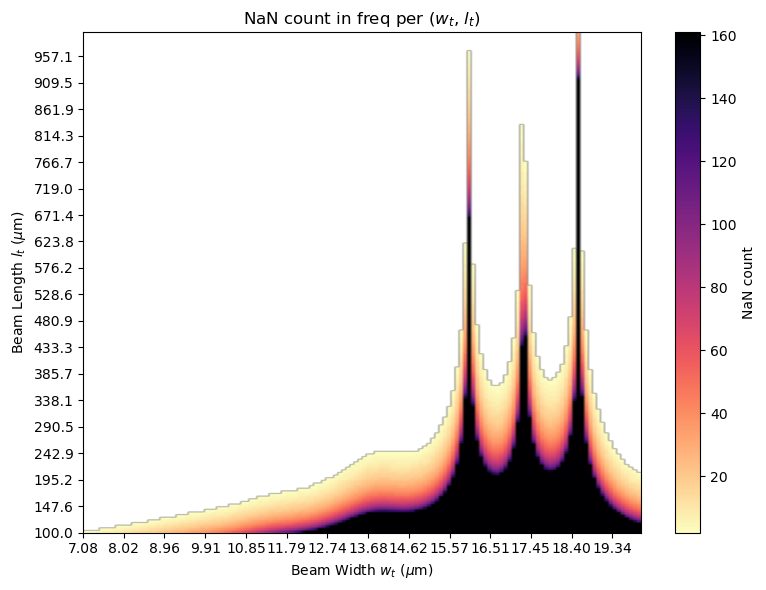

In [6]:
import matplotlib.pyplot as plt
import numpy as np

# 1. 构建 grid
w_t_vals = sorted(nan_df['w_t'].unique())
l_t_vals = sorted(nan_df['l_t'].unique())
grid = nan_df.pivot(index='l_t', columns='w_t', values='n_nan').values

# 2. 绘制 imshow，并用 extent 设置坐标范围
plt.figure(figsize=(8,6))
im = plt.imshow(
    grid,
    extent=[w_t_vals[0]*1e6, w_t_vals[-1]*1e6, l_t_vals[0]*1e6, l_t_vals[-1]*1e6],
    aspect='auto', origin='lower', cmap='magma_r'
)
plt.xlabel(r'Beam Width $w_t$ ($\mu$m)')
plt.ylabel(r'Beam Length $l_t$ ($\mu$m)')
plt.title('NaN count in freq per ($w_t$, $l_t$)')

# 设置每隔多少个 tick 显示一次（比如每隔 2 个）
w_step = 10
l_step = 10

plt.xticks(np.round(np.array(w_t_vals[::w_step]) * 1e6, 2))
plt.yticks(np.round(np.array(l_t_vals[::l_step]) * 1e6, 2))


# 4. 可选：更优美的colorbar
plt.colorbar(im, label='NaN count')

plt.tight_layout()
plt.savefig('./viz/wt_lt_nan_count_big.png', dpi=300)
plt.show()


### 根据完整参数空间，自动生成每组 $(w_t, l_t)$ 下无 nan 的有效响应区间，并保存到 data_valid
本步骤遍历所有参数组合，对无 nan 样本直接全部保留，对有 nan 的样本则参考 nan_idx 剔除无效采样点，统一保存到 data_valid。这样所有可用参数样本均被整合，不会遗漏无缺失数据组。

In [7]:
import pandas as pd
import numpy as np

with pd.HDFStore('./data/wt_lt_big.h5', 'r') as store:
    results_df = store['data']
    constants = store.get_storer('data').attrs.constants
    nan_df = store['nan']

phi = np.array(constants['phi'])

# 构建 (w_t, l_t) -> nan信息的字典
nan_info_dict = {}
for _, row in nan_df.iterrows():
    key = (row['w_t'], row['l_t'])
    nan_info_dict[key] = {
        'valid': row['valid'],
        'nan_idx': np.array(row['nan_idx'], dtype=np.int_)
    }

data_valid = []
for idx, row in results_df.iterrows():
    w_t, l_t = row['w_t'], row['l_t']
    key = (w_t, l_t)
    freq = np.array(row['freq'])
    m_c = np.array(row['m_c'])
    # 如果有nan信息
    if key in nan_info_dict:
        nan_info = nan_info_dict[key]
        # valid==0直接跳过
        if nan_info['valid'] != 1:
            continue
        # 剔除nan点
        all_idx = np.arange(len(freq))
        valid_idx = np.setdiff1d(all_idx, nan_info['nan_idx'])
        freq = freq[valid_idx]
        m_c = m_c[valid_idx]
        phi_valid = phi[valid_idx]
    else:
        # 没有nan，全部保留
        phi_valid = phi
    # 计算统计量
    fmin, fmax = np.min(freq), np.max(freq)
    mmin, mmax = np.min(m_c), np.max(m_c)
    # center点（取phi=90度最近的点）
    phi_deg = phi_valid * 180 / np.pi
    idx_90 = np.argmin(np.abs(phi_deg - 90))
    freq_center = freq[idx_90]
    m_c_center = m_c[idx_90]

    entry = row.copy()
    entry['freq'] = freq
    entry['m_c'] = m_c
    entry['phi'] = phi_valid
    entry['freq_min'] = fmin
    entry['freq_max'] = fmax
    entry['freq_center'] = freq_center
    entry['m_c_min'] = mmin
    entry['m_c_max'] = mmax
    entry['m_c_center'] = m_c_center
    data_valid.append(entry)

results_valid_df = pd.DataFrame(data_valid)
print(f"有效参数组总数: {len(results_valid_df)}")

with pd.HDFStore('./data/wt_lt_big.h5', 'a') as store:
    store['data_valid'] = results_valid_df
print("已将所有有效响应数据（无nan）保存到 ['data_valid']，后续可直接调用。")


有效参数组总数: 27480
已将所有有效响应数据（无nan）保存到 ['data_valid']，后续可直接调用。


/var/folders/n7/v600f1k91rjfkqj_812w6ts40000gn/T/ipykernel_99561/3427106528.py:66: PerformanceWarning: 
your performance may suffer as PyTables will pickle object types that it cannot
map directly to c-types [inferred_type->mixed,key->block1_values] [items->Index(['freq', 'm_c', 'phi'], dtype='object')]

  store['data_valid'] = results_valid_df


## 数据有效性与剔除NaN后的数据分布可视化

本部分用于对已剔除nan后的`data_valid`数据集进行多角度可视化和统计分析。
目的是**验证数据清洗效果、把握可用样本的分布特征，并为后续网络输入方案设计提供直观参考**。

### 1. 单样本完整响应曲线抽查

随机选取若干组样本，直接画出其\$\phi\$-freq和\$\phi\$-m\_c曲线，确认数据连续性与物理合理性。

### 2. 样本统计总览

包含参数分布的describe统计、样本起止点可视化等，辅助评估后续模型输入策略。

### 3. 样本有效区间的起止点分布

可视化所有样本剔除nan后有效$\phi$区间的位置，观察哪些\$\phi\$区间为主响应区，进一步优化采样或网络mask策略。
### 4.  $(w_t, l_t)$参数面有效长度分布
在参数面上直观展示每组参数下有效响应点的空间分布特征，发现“数据充足区”和“数据稀疏区”


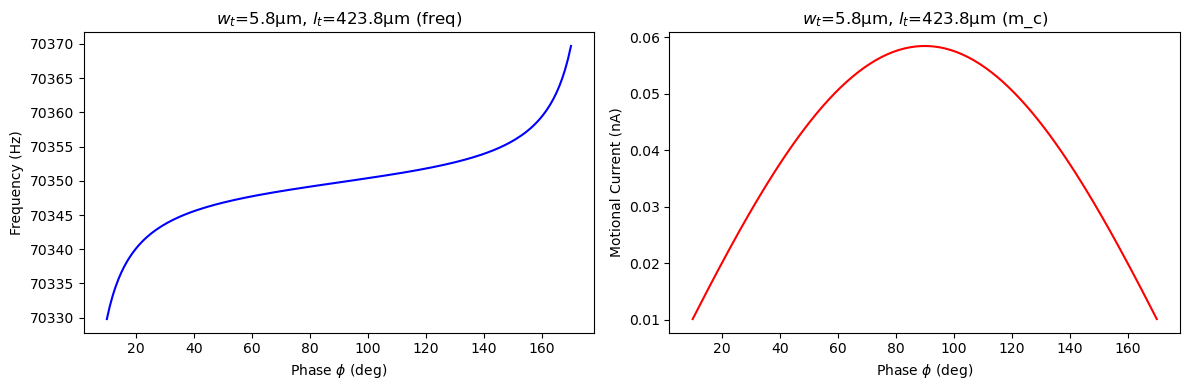

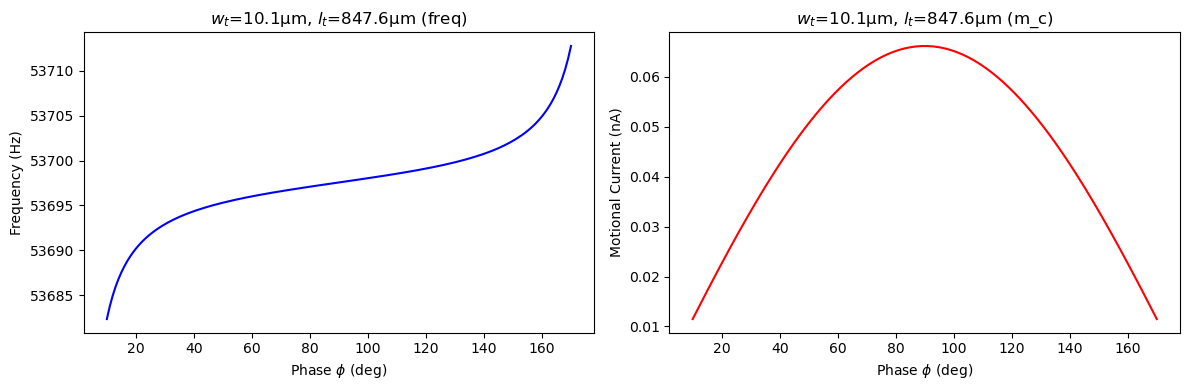

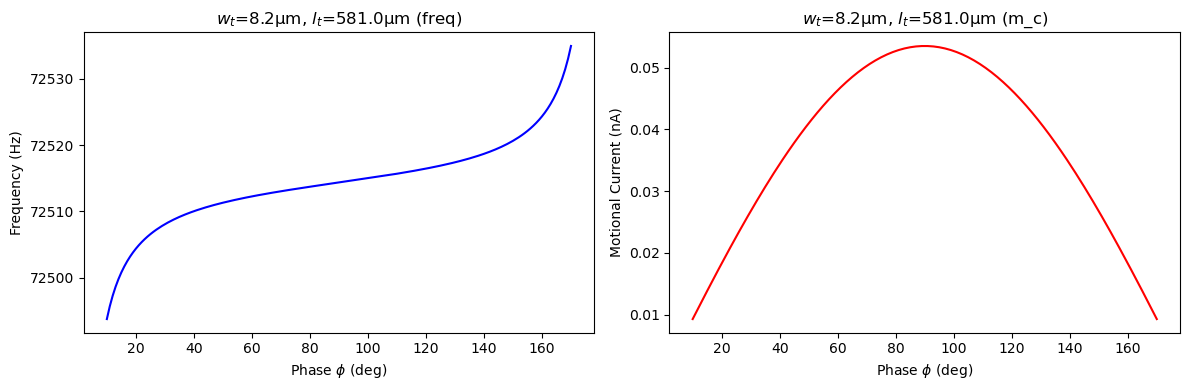

                w_t           l_t
count  27480.000000  27480.000000
mean       0.000012      0.000583
std        0.000004      0.000248
min        0.000005      0.000100
25%        0.000008      0.000376
50%        0.000012      0.000590
75%        0.000015      0.000795
max        0.000020      0.001000


,w_t,l_t,m_coef_b,k_coef_b,k_coef_b3,k_tt,k_t3,Mass,omega_0,freq_0,...,k_e3,freq,m_c,phi,freq_min,freq_max,freq_center,m_c_min,m_c_max,m_c_center
0,0.000005,0.000100,0.396481,198.450892,12.564205,8733.906424,2.654188e+14,8.503475e-10,3.204838e+06,510065.764142,...,1.991705e+09,"[509920.10146361956, 509933.53112284007, 50994...","[0.001474128655685277, 0.0016198097303767487, ...","[0.17453292519943295, 0.19198621771937624, 0.2...",509920.101464,510209.374133,510064.717377,0.001474,0.008489,0.008489
1,0.000005,0.000105,0.396481,198.450892,12.564205,7596.234728,2.308456e+14,8.508974e-10,2.987862e+06,475533.066487,...,1.991705e+09,"[475397.1193583882, 475409.6397970529, 475420....","[0.0015801564696394052, 0.0017363157653629787,...","[0.17453292519943295, 0.19198621771937624, 0.2...",475397.119358,475666.807562,475531.944447,0.001580,0.009100,0.009100
2,0.000005,0.000110,0.396481,198.450892,12.564205,6647.876008,2.020255e+14,8.514473e-10,2.794233e+06,444715.949112,...,1.991705e+09,"[444588.6623870562, 444600.3714336996, 444610....","[0.0016885640665375012, 0.0018554367658435412,...","[0.17453292519943295, 0.19198621771937624, 0.2...",444588.662387,444840.873335,444714.750110,0.001689,0.009724,0.009724
3,0.000005,0.000114,0.396481,198.450892,12.564205,5851.034967,1.778099e+14,8.519972e-10,2.620579e+06,417078.116609,...,1.991705e+09,"[416958.58723446453, 416969.5685973574, 416978...","[0.0017992953548858033, 0.001977111097070995, ...","[0.17453292519943295, 0.19198621771937624, 0.2...",416958.587234,417195.123988,417076.838999,0.001799,0.010362,0.010362
4,0.000005,0.000119,0.396481,198.450892,12.564205,5176.621273,1.573148e+14,8.525470e-10,2.464132e+06,392178.833972,...,1.991705e+09,"[392066.2838912764, 392076.60967446235, 392085...","[0.0019122977183286215, 0.0021012809428672275,...","[0.17453292519943295, 0.19198621771937624, 0.2...",392066.283891,392288.699560,392177.476146,0.001912,0.011012,0.011012


,w_t,l_t,m_coef_b,k_coef_b,k_coef_b3,k_tt,k_t3,Mass,omega_0,freq_0,...,k_e3,freq,m_c,phi,freq_min,freq_max,freq_center,m_c_min,m_c_max,m_c_center
30395,0.00002,0.000981,0.396481,198.450892,12.564205,592.167723,1.124729e+12,1.291903e-09,677029.312007,107752.561624,...,1.991705e+09,"[107718.74940904015, 107721.58645677107, 10772...","[0.00459304415544787, 0.005046952710912439, 0....","[0.17453292519943295, 0.19198621771937624, 0.2...",107718.749409,107779.858923,107749.300079,0.004593,0.026450,0.026450
30396,0.00002,0.000986,0.396481,198.450892,12.564205,583.626975,1.108507e+12,1.294102e-09,671557.795545,106881.742733,...,1.991705e+09,"[106848.15642887796, 106850.97054861739, 10685...","[0.004622595782781223, 0.005079424784037412, 0...","[0.17453292519943295, 0.19198621771937624, 0.2...",106848.156429,106908.772077,106878.460206,0.004623,0.026620,0.026620
30397,0.00002,0.000990,0.396481,198.450892,12.564205,575.249683,1.092596e+12,1.296302e-09,666154.779866,106021.826080,...,1.991705e+09,"[105988.46257182812, 105991.25405062451, 10599...","[0.004652181403036187, 0.00511193420944163, 0....","[0.17453292519943295, 0.19198621771937624, 0.2...",105988.462572,106048.590537,106018.522547,0.004652,0.026791,0.026791
30398,0.00002,0.000995,0.396481,198.450892,12.564205,567.031955,1.076988e+12,1.298501e-09,660819.096390,105172.625680,...,1.991705e+09,"[105139.48190528079, 105142.25102528585, 10514...","[0.00468180079073397, 0.005144480739363315, 0....","[0.17453292519943295, 0.19198621771937624, 0.2...",105139.481905,105199.128265,105169.301118,0.004682,0.026961,0.026961
30399,0.00002,0.001000,0.396481,198.450892,12.564205,558.970011,1.061675e+12,1.300701e-09,655549.601816,104333.959571,...,1.991705e+09,"[104301.03251908087, 104303.7795576553, 104306...","[0.004711453722520558, 0.00517706412837544, 0....","[0.17453292519943295, 0.19198621771937624, 0.2...",104301.032519,104360.203248,104330.613955,0.004711,0.027132,0.027132


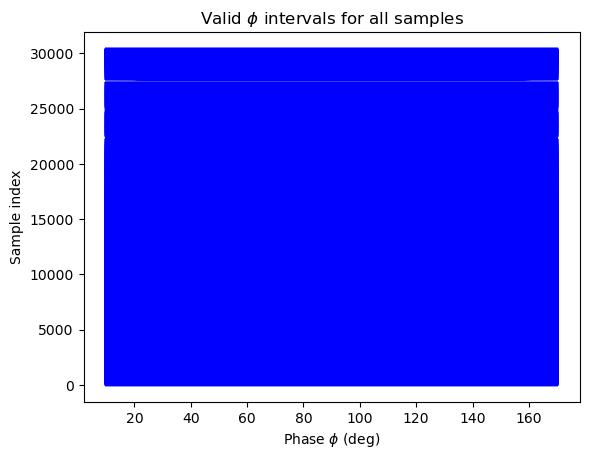

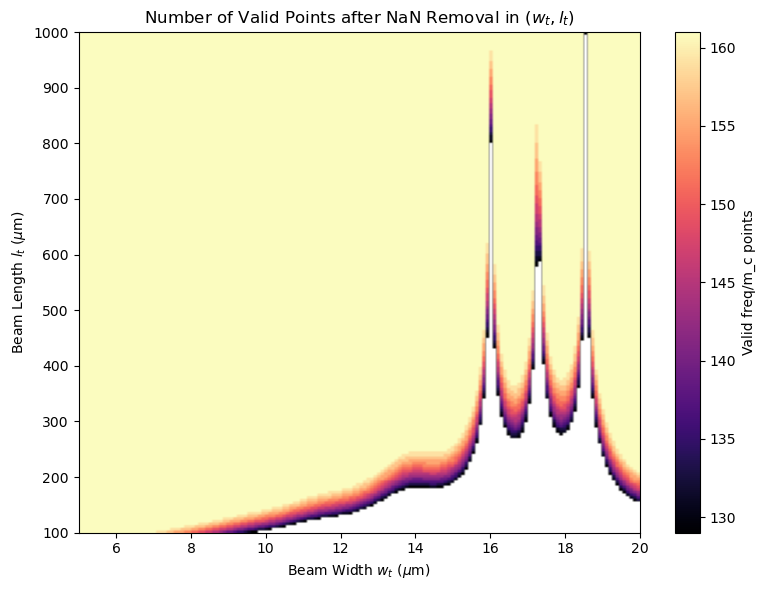

In [8]:
import matplotlib.pyplot as plt

with pd.HDFStore('./data/wt_lt_big.h5', 'r') as store:
    results_df = store['data']
    constants = store.get_storer('data').attrs.constants
    results_valid_df = store['data_valid']

phi = np.array(constants['phi'])

phi_deg = lambda phi: np.array(phi) * 180 / np.pi

# 随机选择3个样本展示
samples = results_valid_df.sample(3, random_state=42)

for i, row in samples.iterrows():
    plt.figure(figsize=(12,4))
    plt.subplot(1,2,1)
    plt.plot(phi_deg(row['phi']), row['freq'], 'b-')
    plt.xlabel(r'Phase $\phi$ (deg)')
    plt.ylabel('Frequency (Hz)')
    plt.title(f"$w_t$={row['w_t']*1e6:.1f}μm, $l_t$={row['l_t']*1e6:.1f}μm (freq)")

    plt.subplot(1,2,2)
    plt.plot(phi_deg(row['phi']), row['m_c'], 'r-')
    plt.xlabel(r'Phase $\phi$ (deg)')
    plt.ylabel('Motional Current (nA)')
    plt.title(f"$w_t$={row['w_t']*1e6:.1f}μm, $l_t$={row['l_t']*1e6:.1f}μm (m_c)")

    plt.tight_layout()
    plt.show()

# 简明统计
print(results_valid_df[['w_t', 'l_t']].describe())

# 头部、尾部
display(results_valid_df.head())
display(results_valid_df.tail())


for i, row in results_valid_df.iterrows():
    phi_vals = np.array(row['phi'])
    plt.plot([phi_vals[0]*180/np.pi, phi_vals[-1]*180/np.pi], [i, i], 'b-', alpha=0.3)

plt.xlabel(r'Phase $\phi$ (deg)')
plt.ylabel('Sample index')
plt.title('Valid $\phi$ intervals for all samples')
plt.show()


w_t_list = sorted(results_valid_df['w_t'].unique())
l_t_list = sorted(results_valid_df['l_t'].unique())
wtlt_grid = np.full((len(l_t_list), len(w_t_list)), np.nan)
for i, l_t in enumerate(l_t_list):
    for j, w_t in enumerate(w_t_list):
        subset = results_valid_df[(results_valid_df['w_t']==w_t) & (results_valid_df['l_t']==l_t)]
        if len(subset) > 0:
            wtlt_grid[i, j] = len(subset.iloc[0]['freq'])

plt.figure(figsize=(8,6))
plt.imshow(wtlt_grid, extent=[w_t_list[0]*1e6, w_t_list[-1]*1e6, l_t_list[0]*1e6, l_t_list[-1]*1e6],
           aspect='auto', origin='lower', cmap='magma')
plt.xlabel(r'Beam Width $w_t$ ($\mu$m)')
plt.ylabel(r'Beam Length $l_t$ ($\mu$m)')
plt.title('Number of Valid Points after NaN Removal in $(w_t, l_t)$')
plt.colorbar(label='Valid freq/m_c points')
plt.tight_layout()
plt.show()




In [9]:
import matplotlib.pyplot as plt
import numpy as np
from ipywidgets import interact, fixed, Dropdown, Button, HBox, VBox, Output
import pandas as pd


with pd.HDFStore('./data/wt_lt_big.h5', 'r') as store:
    results_df = store['data']
    # 如果你需要常数参数，可同时加载
    constants = store.get_storer('data').attrs.constants
    results_valid_df = store['data_valid']

# 确保w_t_list, l_t_list为有序唯一数组
w_t_list = sorted(results_valid_df['w_t'].unique())
l_t_list = sorted(results_valid_df['l_t'].unique())
phi_deg = constants['phi'] * 180 / np.pi

# 生成可选项映射（μm显示更友好）
w_t_choices = {f'{w*1e6:.2f} μm': w for w in w_t_list}
l_t_choices = {f'{l*1e6:.2f} μm': l for l in l_t_list}

# 下拉框
w_t_dropdown = Dropdown(
    options=w_t_choices,
    value=w_t_list[0],
    description='w_t:',
    style={'description_width': 'initial'},
    layout={'width': '200px'}
)
l_t_dropdown = Dropdown(
    options=l_t_choices,
    value=l_t_list[0],
    description=r'l_t:',
    style={'description_width': 'initial'},
    layout={'width': '200px'}
)

btn = Button(description="显示", button_style='success')
out = Output()

def plot_selected(w_t, l_t):
    with out:
        out.clear_output()
        row = results_df[(results_df['w_t']==w_t) & (results_df['l_t']==l_t)].iloc[0]
        freq = np.array(row['freq'])
        m_c = np.array(row['m_c'])
        fig, axs = plt.subplots(1, 2, figsize=(12,5))
        axs[0].plot(phi_deg, freq, 'b-', lw=2)
        axs[0].set_xlabel(r'Phase $\phi$ (deg)')
        axs[0].set_ylabel('Frequency (Hz)')
        axs[0].set_title(rf'Frequency ($w_t$={w_t*1e6:.2f}$\mu$m, $l_t$={l_t*1e6:.2f}$\mu$m)')
        axs[0].grid(True)
        axs[1].plot(phi_deg, m_c, 'r-', lw=2)
        axs[1].set_xlabel(r'Phase $\phi$ (deg)')
        axs[1].set_ylabel('Motional Current (nA)')
        axs[1].set_title(rf'Motional Current ($w_t$={w_t*1e6:.2f}$\mu$m, $l_t$={l_t*1e6:.2f}$\mu$m)')
        axs[1].grid(True)
        plt.tight_layout()
        plt.show()

def on_click(btn):
    plot_selected(w_t_dropdown.value, l_t_dropdown.value)

btn.on_click(on_click)

ui = HBox([w_t_dropdown, l_t_dropdown, btn])
display(VBox([ui, out]))

# 初始化一次
plot_selected(w_t_dropdown.value, l_t_dropdown.value)
